In [2]:
import ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.colors import ListedColormap
import math

df = pd.read_csv("Cleaned_DF.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [3]:
mask1 = (df['CryoSleep']==0)&(df['Age']>12.5)
features = ['Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Deck','Num','Side','route']
dz = df[mask1][features+["Transported"]]
dz.shape

(4447, 12)

LDA

MV 1: [-5.3163e-03  1.5682e-04  1.0700e-01 -1.6002e-01 -1.1772e-01  1.0652e-01
  9.5508e-02  5.1048e-02  2.4304e-02 -7.8162e-02 -3.3554e-02]

MV 2: [ 1.2183e-02 -3.5937e-04 -2.4522e-01  3.6670e-01  2.6977e-01 -2.4411e-01
 -2.1887e-01 -1.1698e-01 -5.5695e-02  1.7912e-01  7.6894e-02]

Собственные значения в порядке убывания:

72.73116159903164
5.133709152066172e-15
3.621852494608057e-15
3.621852494608057e-15
2.4468366115081742e-15
2.4468366115081742e-15
1.5887279651635437e-15
1.5887279651635437e-15
7.400643540543546e-16
1.1478325606486888e-16
0.0


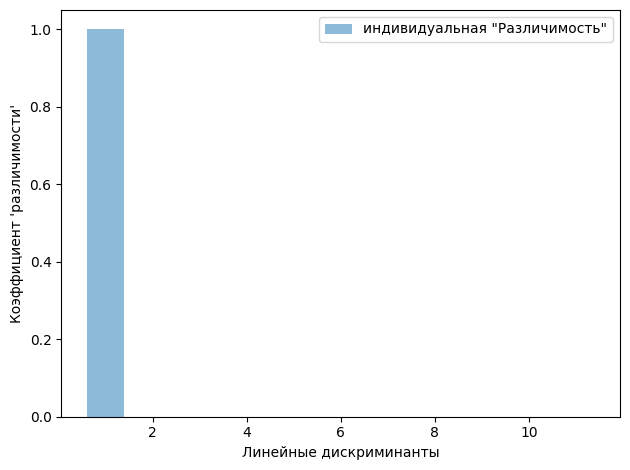

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y = dz["Transported"]
X = dz[features]
X_std = sc.fit_transform(X)

np.set_printoptions(precision = 4)
mean_vecs = []
labels = [-1.0,1.0]
for label in range(1,len(labels)+1):
    mean_vecs.append(np.mean(X_std[y == labels[label-1]],axis = 0))
    print('MV %s: %s\n'%(label,mean_vecs[label-1]))

d = len(features)
S_W = np.zeros((d,d))
for label , mv in zip(labels , mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_std[y == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
#print ('Матрица раcсеяния внутри классов: %sx%s'%(S_W.shape[0], S_W.shape[1]))

S_W = np.zeros((d,d))
for label,mv in zip(labels, mean_vecs):
    class_scatter = np.cov(X_std[y==label].T)
    S_W += class_scatter
#print('Масштабированная матрица рассеяния внутри классов: %sx%s' % (S_W.shape[0], S_W.shape[1]) )

mean_overall = np.mean(X_std, axis= 0)
S_B = np.zeros((d,d))
for i , mean_vec in enumerate(mean_vecs):
    n = X_std[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B +=n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
#print('Матрица рассеяния между классами: %sx%s'%(S_B.shape[0],S_B.shape[1]))

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs=sorted(eigen_pairs, key = lambda k: k[0], reverse = True)

print('Собственные значения в порядке убывания:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted (eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)
size = len(features)+1
plt.bar(range(1,size),discr, alpha = 0.5, align = 'center',label = 'индивидуальная "Различимость"')
plt.ylabel("Коэффициент 'различимости'")
plt.xlabel('Линейные дискриминанты')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [5]:
w = eigen_pairs[0][1][:,np.newaxis].real
print('Матрица W:\n',w)

Матрица W:
 [[ 0.019 ]
 [-0.0346]
 [-0.4079]
 [ 0.3974]
 [ 0.2669]
 [-0.5227]
 [-0.4919]
 [-0.1858]
 [-0.0011]
 [ 0.2304]
 [-0.0108]]


In [ ]:
X_lda = X_std.dot(w)

colors = ['r','b']
markers = ['s','x']
for l,c,m in zip(np.unique(y),colors, markers):
    plt.scatter(X_lda[y == l, 0],X_lda[y == l, 1],c = c, label = l, marker = m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show